# 🛠 10. Time series fundamentals and Milestone Project 3: BitPredict 💰📈 Exercises

1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1) 
  * Try doing this for a univariate model (e.g. `model_1`) and a multivariate model (e.g. `model_6`) and see if it effects model training or evaluation results.
2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).
  * You can download the Bitcoin historical data for free from [coindesk.com/price/bitcoin](https://www.coindesk.com/price/bitcoin) and clicking "Export Data" -> "CSV".
3. For most of our models we used `WINDOW_SIZE=7`, but is there a better window size?
  * Setup a series of experiments to find whether or not there's a better window size.
  * For example, you might train 10 different models with `HORIZON=1` but with window sizes ranging from 2-12.
4. Create a windowed dataset just like the ones we used for `model_1` using [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array) and retrain `model_1` using the recreated dataset.
5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate. 
  * Are there any other features you think you could add? 
  * If so, try it out, how do these affect the model?
6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for `model_8`.
7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn't retrained for every forecast (`model_9`)?
8. Throughout this notebook, we've only tried algorithms we've handcrafted ourselves. But it's worth seeing how a purpose built forecasting algorithm goes. 
  * Try out one of the extra algorithms listed in the modelling experiments part such as:
    * [Facebook's Kats library](https://github.com/facebookresearch/Kats) - there are many models in here, remember the machine learning practioner's motto: experiment, experiment, experiment.
    * [LinkedIn's Greykite library](https://github.com/linkedin/greykite)

## 1. Scale univariate and multivariate model

### Get Data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin/

In [1]:
!curl -o C:/Users/User/Time_series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  174k  100  174k    0     0   517k      0 --:--:-- --:--:-- --:--:--  518k


### Importing time series with pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) #Parse the date column and tell pandas column 1 is a datetime
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# How many samples do we have ?
len(df)

2787

We've collected the historical price of Bitcoin for ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (thousands to ten of thousands to millions).

A smaller number of samples is something you'll often run into with time series datav problems.

> 🔑 **Note:** The seasonality of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year. 

In [4]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


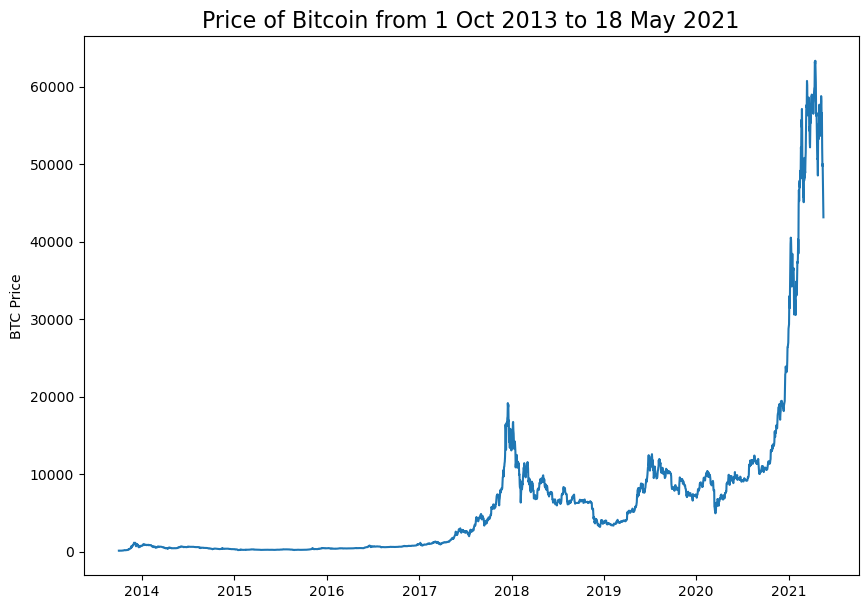

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(bitcoin_prices.index, bitcoin_prices.Price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16);

### Format data part 1: Create train and test sets for our time series data

In [5]:
# Get bitcoin date  array 
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

In [6]:
# Create train & test splits the wright way for time series data
split_size = int(0.8 * len(prices)) # train

# Create train data split (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data split
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2229, 2229, 558, 558)

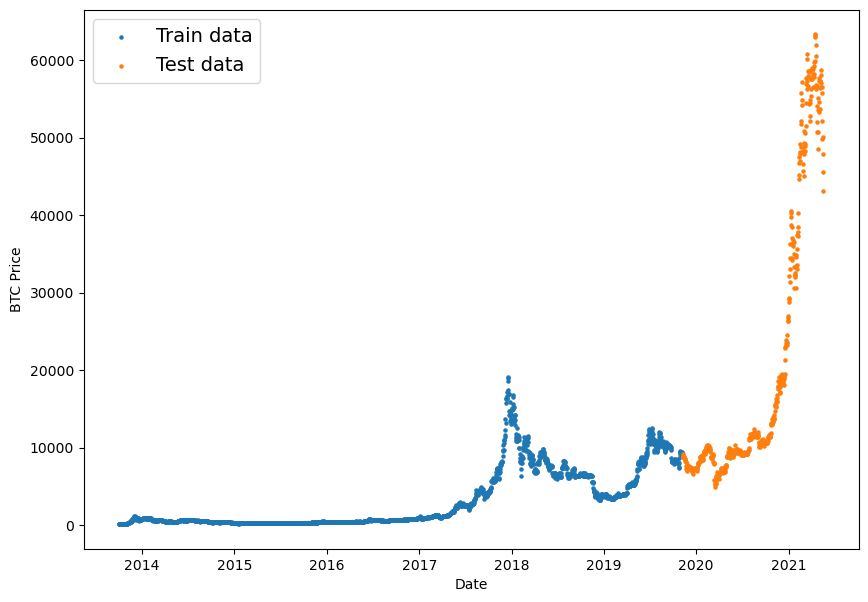

In [9]:
# Plot splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show();

### Create a plotting function

In [7]:
# Create a function to plot time series data 
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).
    
    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across times
    format : style of plot, default "." 
    start : where to start the plot (setting a value will index from start of timesteps & values) 
    end : where to end the plot (similar to start but for the end) 
    label: label to show on plot about values, default None
    """   
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

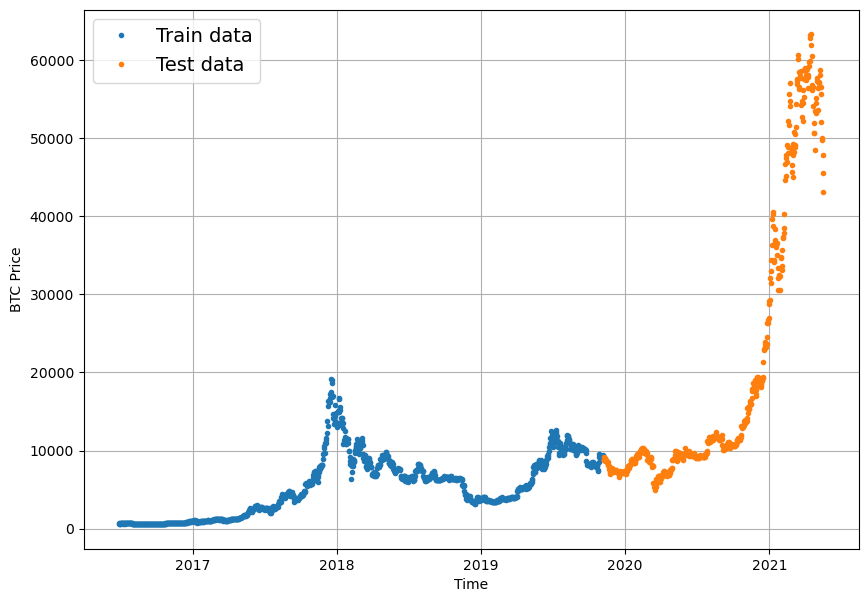

In [11]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, start=1000, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

### Modelling experiments

## Format Data Part 2: Windowing our dataset

Why do we window ?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7] 
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [8]:
# Let's setup global variables for window horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [9]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    """
    Create labels for windowed dataset.
    
    E.g if horizon=1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output:([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:,-horizon: ]   

In [10]:
import numpy as np
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    
    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # Create 2D of windows of size window_size
    
    # 3. Index on the target array (a time series) with 2D array of multiple windows steps
    windowed_array = x[window_indexes]
    
    # 4. Get the labelled windows 
    windows, labels = get_labelled_windows(windowed_array, horizon)
    
    return windows, labels

In [11]:
# Scale our values between 0 and 1
prices = prices / np.max(prices)

In [12]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

### Turning windows into training and test sets

In [13]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size=int(len(windows)* (1-test_split)) # This will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    
    return train_windows, test_windows, train_labels, test_labels

In [14]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

### Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but were training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

In [15]:
# Import our checkpoint callback function
from course_ztm import CreateModelCheckpoint

### Model 1: Dense model (window=7, horizon=1)

Our first deep model is going to be a simple dense model:

A single dense layer with 128 hidden units and ReLu
An output layer with linear activation (no activation)
Adam optimizer and MAE loss function
Batch size of 128 # Because our data are small only 7 numbers
100 epochs
Why these values ?

From experimentation.

Hyperparameters = values a machine learning practionner can adjust themselves.
Parameters = values a model learns on its own.

In [20]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for a reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model 
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation.
], name="model_1_dense") # name our model so we can save it.

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[CreateModelCheckpoint("C:/Users/User/Time_series/checkpoints/exercices/"+model_1.name,"val_loss", False)])

Epoch 1/100
 1/18 [>.............................] - ETA: 10s - loss: 0.0373 - mae: 0.0373 - mse: 0.0029

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 1s 31ms/step - loss: 0.0128 - mae: 0.0128 - mse: 5.4815e-04 - val_loss: 0.0243 - val_mae: 0.0243 - val_mse: 0.0018
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0062 - mae: 0.0062 - mse: 1.0797e-04

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 0.0045 - mae: 0.0045 - mse: 7.1434e-05 - val_loss: 0.0170 - val_mae: 0.0170 - val_mse: 9.7363e-04
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0034 - mse: 4.9110e-05 - val_loss: 0.0176 - val_mae: 0.0176 - val_mse: 9.5500e-04
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0041 - mae: 0.0041 - mse: 6.6879e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 15ms/step - loss: 0.0032 - mae: 0.0032 - mse: 4.8320e-05 - val_loss: 0.0165 - val_mae: 0.0165 - val_mse: 8.8917e-04
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.0030 - mse: 4.5194e-05 - val_loss: 0.0167 - val_mae: 0.0167 - val_mse: 8.7703e-04
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0022 - mae: 0.0022 - mse: 1.6880e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 21ms/step - loss: 0.0029 - mae: 0.0029 - mse: 4.2695e-05 - val_loss: 0.0161 - val_mae: 0.0161 - val_mse: 8.1904e-04
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0034 - mae: 0.0034 - mse: 8.4084e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0028 - mae: 0.0028 - mse: 3.9977e-05 - val_loss: 0.0159 - val_mae: 0.0159 - val_mse: 7.8336e-04
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0024 - mae: 0.0024 - mse: 2.1774e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0027 - mae: 0.0027 - mse: 3.6948e-05 - val_loss: 0.0153 - val_mae: 0.0153 - val_mse: 7.2326e-04
Epoch 9/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0026 - mse: 3.5310e-05 - val_loss: 0.0157 - val_mae: 0.0157 - val_mse: 7.4338e-04
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0026 - mae: 0.0026 - mse: 4.8898e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0026 - mae: 0.0026 - mse: 3.3636e-05 - val_loss: 0.0143 - val_mae: 0.0143 - val_mse: 6.4074e-04
Epoch 11/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0025 - mse: 3.0642e-05 - val_loss: 0.0145 - val_mae: 0.0145 - val_mse: 6.4349e-04
Epoch 12/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0024 - mae: 0.0024 - mse: 2.8958e-05 - val_loss: 0.0152 - val_mae: 0.0152 - val_mse: 6.8447e-04
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0020 - mae: 0.0020 - mse: 2.2062e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0024 - mae: 0.0024 - mse: 2.8756e-05 - val_loss: 0.0143 - val_mae: 0.0143 - val_mse: 6.1543e-04
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0023 - mae: 0.0023 - mse: 2.4214e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0022 - mae: 0.0022 - mse: 2.6753e-05 - val_loss: 0.0135 - val_mae: 0.0135 - val_mse: 5.5271e-04
Epoch 15/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0023 - mae: 0.0023 - mse: 2.6428e-05 - val_loss: 0.0146 - val_mae: 0.0146 - val_mse: 6.1133e-04
Epoch 16/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0022 - mae: 0.0022 - mse: 2.4832e-05 - val_loss: 0.0140 - val_mae: 0.0140 - val_mse: 5.7103e-04
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0019 - mae: 0.0019 - mse: 1.6534e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0022 - mae: 0.0022 - mse: 2.3757e-05 - val_loss: 0.0131 - val_mae: 0.0131 - val_mse: 5.1808e-04
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0026 - mae: 0.0026 - mse: 2.9810e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0022 - mae: 0.0022 - mse: 2.3717e-05 - val_loss: 0.0121 - val_mae: 0.0121 - val_mse: 4.7552e-04
Epoch 19/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0020 - mae: 0.0020 - mse: 2.2418e-05 - val_loss: 0.0125 - val_mae: 0.0125 - val_mse: 4.8906e-04
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0021 - mae: 0.0021 - mse: 2.5400e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0020 - mae: 0.0020 - mse: 2.2167e-05 - val_loss: 0.0111 - val_mae: 0.0111 - val_mse: 4.0052e-04
Epoch 21/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0021 - mse: 2.1832e-05 - val_loss: 0.0116 - val_mae: 0.0116 - val_mse: 4.3665e-04
Epoch 22/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0022 - mse: 2.2540e-05 - val_loss: 0.0111 - val_mae: 0.0111 - val_mse: 4.0814e-04
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0021 - mae: 0.0021 - mse: 1.6494e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0020 - mae: 0.0020 - mse: 2.1331e-05 - val_loss: 0.0107 - val_mae: 0.0107 - val_mse: 3.7684e-04
Epoch 24/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0020 - mse: 2.1109e-05 - val_loss: 0.0113 - val_mae: 0.0113 - val_mse: 4.2417e-04
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0023 - mae: 0.0023 - mse: 1.6667e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0023 - mae: 0.0023 - mse: 2.1815e-05 - val_loss: 0.0107 - val_mae: 0.0107 - val_mse: 3.6824e-04
Epoch 26/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0021 - mae: 0.0021 - mse: 2.0822e-05 - val_loss: 0.0111 - val_mae: 0.0111 - val_mse: 3.9997e-04
Epoch 27/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0022 - mse: 2.0555e-05 - val_loss: 0.0117 - val_mae: 0.0117 - val_mse: 4.4219e-04
Epoch 28/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0021 - mae: 0.0021 - mse: 2.0179e-05 - val_loss: 0.0114 - val_mae: 0.0114 - val_mse: 4.3130e-04
Epoch 29/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.9549e-05 - val_loss: 0.0111 - val_mae: 0.0111 - val_mse: 4.0702e-04
Epoch 30/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0020 - mse: 1.9591e-05 - val_loss: 0.0142 - val_mae: 0.0142 - 

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.9001e-05 - val_loss: 0.0106 - val_mae: 0.0106 - val_mse: 3.8301e-04
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0017 - mae: 0.0017 - mse: 1.7085e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0018 - mae: 0.0018 - mse: 1.8899e-05 - val_loss: 0.0101 - val_mae: 0.0101 - val_mse: 3.4537e-04
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0021 - mae: 0.0021 - mse: 2.8741e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.9164e-05 - val_loss: 0.0098 - val_mae: 0.0098 - val_mse: 3.2681e-04
Epoch 40/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0020 - mse: 1.9346e-05 - val_loss: 0.0099 - val_mae: 0.0099 - val_mse: 3.3477e-04
Epoch 41/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.8930e-05 - val_loss: 0.0099 - val_mae: 0.0099 - val_mse: 3.1939e-04
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0020 - mae: 0.0020 - mse: 1.5491e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 20ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.9216e-05 - val_loss: 0.0098 - val_mae: 0.0098 - val_mse: 3.2222e-04
Epoch 43/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.9046e-05 - val_loss: 0.0100 - val_mae: 0.0100 - val_mse: 3.3608e-04
Epoch 44/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.8857e-05 - val_loss: 0.0101 - val_mae: 0.0101 - val_mse: 3.5112e-04
Epoch 45/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0018 - mae: 0.0018 - mse: 1.8532e-05 - val_loss: 0.0106 - val_mae: 0.0106 - val_mse: 3.8077e-04
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0013 - mae: 0.0013 - mse: 1.1259e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.8729e-05 - val_loss: 0.0097 - val_mae: 0.0097 - val_mse: 3.2487e-04
Epoch 47/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0018 - mae: 0.0018 - mse: 1.8883e-05 - val_loss: 0.0120 - val_mae: 0.0120 - val_mse: 4.6450e-04
Epoch 48/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.8969e-05 - val_loss: 0.0111 - val_mae: 0.0111 - val_mse: 4.1479e-04
Epoch 49/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0020 - mse: 1.9294e-05 - val_loss: 0.0098 - val_mae: 0.0098 - val_mse: 3.2862e-04
Epoch 50/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0018 - mae: 0.0018 - mse: 1.8256e-05 - val_loss: 0.0100 - val_mae: 0.0100 - val_mse: 3.3892e-04
Epoch 51/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0018 - mae: 0.0018 - mse: 1.8325e-05 - val_loss: 0.0098 - val_mae: 0.0098 - 

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0018 - mae: 0.0018 - mse: 1.7962e-05 - val_loss: 0.0094 - val_mae: 0.0094 - val_mse: 3.0432e-04
Epoch 57/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0020 - mse: 2.0160e-05 - val_loss: 0.0094 - val_mae: 0.0094 - val_mse: 3.0505e-04
Epoch 58/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0021 - mae: 0.0021 - mse: 1.9396e-05 - val_loss: 0.0098 - val_mae: 0.0098 - val_mse: 3.3499e-04
Epoch 59/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.8334e-05 - val_loss: 0.0103 - val_mae: 0.0103 - val_mse: 3.5668e-04
Epoch 60/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0020 - mse: 1.8321e-05 - val_loss: 0.0102 - val_mae: 0.0102 - val_mse: 3.5206e-04
Epoch 61/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.8929e-05 - val_loss: 0.0128 - val_mae: 0.0128 - 

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0020 - mae: 0.0020 - mse: 1.8682e-05 - val_loss: 0.0093 - val_mae: 0.0093 - val_mse: 3.0097e-04
Epoch 69/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0021 - mae: 0.0021 - mse: 1.9781e-05 - val_loss: 0.0105 - val_mae: 0.0105 - val_mse: 3.6837e-04
Epoch 70/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.8283e-05 - val_loss: 0.0099 - val_mae: 0.0099 - val_mse: 3.3832e-04
Epoch 71/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0021 - mae: 0.0021 - mse: 1.9386e-05 - val_loss: 0.0098 - val_mae: 0.0098 - val_mse: 3.3220e-04
Epoch 72/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0020 - mae: 0.0020 - mse: 1.8657e-05 - val_loss: 0.0095 - val_mae: 0.0095 - val_mse: 3.0622e-04
Epoch 73/100
18/18 [==============================] - 0s 1ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.8275e-05 - val_loss: 0.0119 - val_mae: 0.0119 - 

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 14ms/step - loss: 0.0019 - mae: 0.0019 - mse: 1.8254e-05 - val_loss: 0.0092 - val_mae: 0.0092 - val_mse: 2.9731e-04


In [21]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 587us/step - loss: 0.0092 - mae: 0.0092 - mse: 2.9731e-04


[0.00922426488250494, 0.00922426488250494, 0.0002973054361063987]

In [22]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("C:/Users/User/Time_series/checkpoints/exercices/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 637us/step - loss: 0.0092 - mae: 0.0092 - mse: 2.9731e-04


[0.00922426488250494, 0.00922426488250494, 0.0002973054361063987]

### Making forecasts with the model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions.

In [16]:
def make_preds(model, input_data):
    """
    Uses model to make prediction on input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # Return 1D array of predictions 

In [24]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 413us/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.14170459, 0.1399974 , 0.14400892, 0.1405407 , 0.13921517,
        0.1394969 , 0.13889465, 0.13587868, 0.13520494, 0.13610896],
       dtype=float32)>)

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing ?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squarred error
* RMSE - root mean squarred error
* MAPE/sMAPE - (symmetric) mean absolute percentage error 
* MASE - mean absolute scaled error

The main thing we're evaluating here is: how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than a MAE of 100. 

> 📖 **Resources:** For a deeper dive into the various kinds of time series forecasting methods see: [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html)

In [17]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # Our seasonality is 1 day (hence the shift of 1)
    
    return mae / mae_naive_no_season

In [18]:
from tensorflow.keras import metrics

In [19]:
# Create a function to take in model prediction and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Calculate various evaluation metrics
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [28]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 0.009224263,
 'mse': 0.00029730544,
 'rmse': 0.017242547,
 'mape': 2.7004735,
 'mase': 1.0265014}

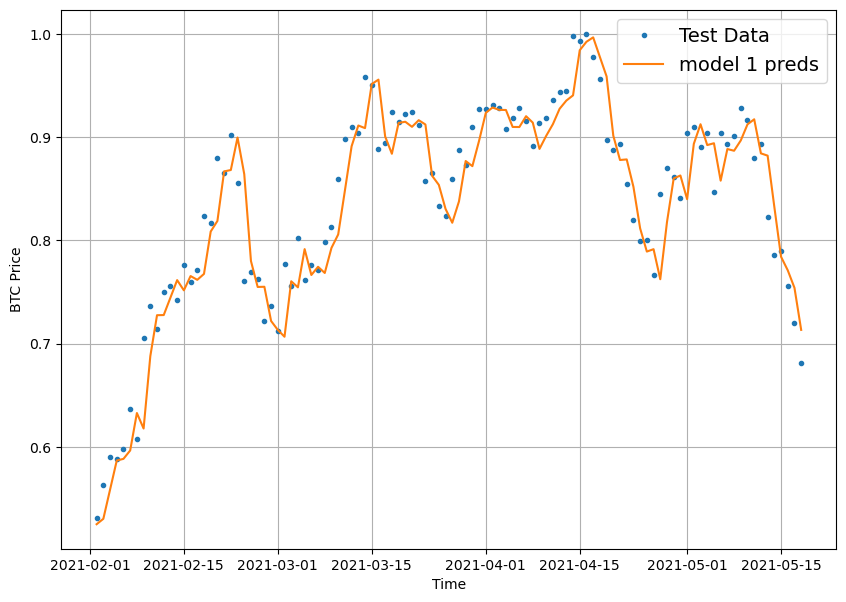

In [29]:
# Let's plot our model 1 predictions
offset=450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:,0],
                 start=offset,
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-", 
                 label="model 1 preds")

### Make a multivariate time series dataset

In [20]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates 
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [21]:
# Create date range of where specific block_reward values should be
bitcoin_prices.loc[(bitcoin_prices.index >= bitcoin_prices.index[0]) & (bitcoin_prices.index < block_reward_3_datetime) , 'block_reward'] = block_reward_2
bitcoin_prices.loc[(bitcoin_prices.index >= block_reward_3_datetime) & (bitcoin_prices.index < block_reward_4_datetime) , 'block_reward'] = block_reward_3
bitcoin_prices.loc[bitcoin_prices.index >= block_reward_4_datetime, 'block_reward'] = block_reward_4
bitcoin_prices

,Price,block_reward
Date,,
2013-10-01,123.654990,25.00
2013-10-02,125.455000,25.00
2013-10-03,108.584830,25.00
2013-10-04,118.674660,25.00
2013-10-05,121.338660,25.00
...,...,...
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25


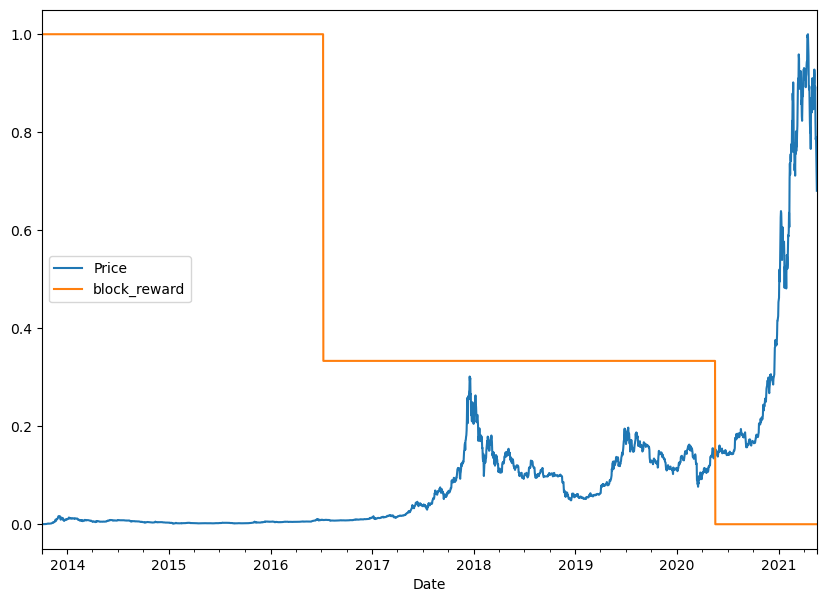

In [32]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices[["Price", "block_reward"]]),
                                    columns=bitcoin_prices.columns,
                                   index=bitcoin_prices.index)
scaled_price_block_df.plot(figsize=(10,7));

In [22]:
# Scale Price and block_reward
bitcoin_prices.Price = bitcoin_prices.Price / np.max(bitcoin_prices.Price)
bitcoin_prices.block_reward = bitcoin_prices.block_reward / np.max(bitcoin_prices.block_reward)
bitcoin_prices

,Price,block_reward
Date,,
2013-10-01,0.001952,1.00
2013-10-02,0.001980,1.00
2013-10-03,0.001714,1.00
2013-10-04,0.001873,1.00
2013-10-05,0.001915,1.00
...,...,...
2021-05-14,0.785583,0.25
2021-05-15,0.789822,0.25
2021-05-16,0.755928,0.25


## Making a windowed dataset with pandas

In [23]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [24]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,0.001952,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,0.001980,1.0,0.001952,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,0.001714,1.0,0.001980,0.001952,NaN,NaN,NaN,NaN,NaN
2013-10-04,0.001873,1.0,0.001714,0.001980,0.001952,NaN,NaN,NaN,NaN
2013-10-05,0.001915,1.0,0.001873,0.001714,0.001980,0.001952,NaN,NaN,NaN
2013-10-06,0.001905,1.0,0.001915,0.001873,0.001714,0.001980,0.001952,NaN,NaN
2013-10-07,0.001923,1.0,0.001905,0.001915,0.001873,0.001714,0.001980,0.001952,NaN
2013-10-08,0.001942,1.0,0.001923,0.001905,0.001915,0.001873,0.001714,0.001980,0.001952
2013-10-09,0.001958,1.0,0.001942,0.001923,0.001905,0.001915,0.001873,0.001714,0.001980


In [25]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,1.0,0.001923,0.001905,0.001915,0.001873,0.001714,0.001980,0.001952
2013-10-09,1.0,0.001942,0.001923,0.001905,0.001915,0.001873,0.001714,0.001980
2013-10-10,1.0,0.001958,0.001942,0.001923,0.001905,0.001915,0.001873,0.001714
2013-10-11,1.0,0.001988,0.001958,0.001942,0.001923,0.001905,0.001915,0.001873
2013-10-12,1.0,0.001978,0.001988,0.001958,0.001942,0.001923,0.001905,0.001915


In [26]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Model 6: Dense (multivariate time series)

In [48]:
# Set random seed for a reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model 
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation.
], name="model_6_multivariate") # name our model so we can save it.

# 2. Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_6.fit(x=X_train,
            y=y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[CreateModelCheckpoint("C:/Users/User/Time_series/checkpoints/exercices/"+model_6.name,"val_loss", False)])

Epoch 1/100
 1/18 [>.............................] - ETA: 4s - loss: 0.0576 - mae: 0.0576 - mse: 0.0052

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_6_multivariate\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_6_multivariate\assets


18/18 [==============================] - 1s 21ms/step - loss: 0.0214 - mae: 0.0214 - mse: 9.5019e-04 - val_loss: 0.0539 - val_mae: 0.0539 - val_mse: 0.0095
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0053 - mae: 0.0053 - mse: 6.0447e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_6_multivariate\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_6_multivariate\assets


18/18 [==============================] - 0s 17ms/step - loss: 0.0065 - mae: 0.0065 - mse: 7.7098e-05 - val_loss: 0.0476 - val_mae: 0.0476 - val_mse: 0.0074
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0056 - mae: 0.0056 - mse: 6.0316e-05 - val_loss: 0.0563 - val_mae: 0.0563 - val_mse: 0.0097
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0047 - mae: 0.0047 - mse: 5.1335e-05 - val_loss: 0.0567 - val_mae: 0.0567 - val_mse: 0.0101
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0034 - mse: 4.0512e-05 - val_loss: 0.0576 - val_mae: 0.0576 - val_mse: 0.0104
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0041 - mae: 0.0041 - mse: 4.1524e-05 - val_loss: 0.0633 - val_mae: 0.0633 - val_mse: 0.0123
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0061 - mae: 0.0061 - mse: 6.6960e-05 - val_loss: 0.0632 - val_mae: 0.0632 - val_mse: 0.0121
Epoch 8/1

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_6_multivariate\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_6_multivariate\assets


18/18 [==============================] - 0s 17ms/step - loss: 0.0044 - mae: 0.0044 - mse: 3.5859e-05 - val_loss: 0.0458 - val_mae: 0.0458 - val_mse: 0.0068
Epoch 34/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0044 - mae: 0.0044 - mse: 3.7486e-05 - val_loss: 0.0549 - val_mae: 0.0549 - val_mse: 0.0093
Epoch 35/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0029 - mse: 2.4454e-05 - val_loss: 0.0606 - val_mae: 0.0606 - val_mse: 0.0110
Epoch 36/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0034 - mse: 2.7370e-05 - val_loss: 0.0495 - val_mae: 0.0495 - val_mse: 0.0076
Epoch 37/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0065 - mae: 0.0065 - mse: 6.4544e-05 - val_loss: 0.0574 - val_mae: 0.0574 - val_mse: 0.0095
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0065 - mae: 0.0065 - mse: 5.4971e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_6_multivariate\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_6_multivariate\assets


18/18 [==============================] - 0s 17ms/step - loss: 0.0058 - mae: 0.0058 - mse: 5.4657e-05 - val_loss: 0.0456 - val_mae: 0.0456 - val_mse: 0.0065
Epoch 39/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0041 - mae: 0.0041 - mse: 3.4505e-05 - val_loss: 0.0552 - val_mae: 0.0552 - val_mse: 0.0090
Epoch 40/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0028 - mae: 0.0028 - mse: 2.2725e-05 - val_loss: 0.0595 - val_mae: 0.0595 - val_mse: 0.0104
Epoch 41/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0029 - mse: 2.2436e-05 - val_loss: 0.0572 - val_mae: 0.0572 - val_mse: 0.0099
Epoch 42/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0049 - mae: 0.0049 - mse: 4.0438e-05 - val_loss: 0.0548 - val_mae: 0.0548 - val_mse: 0.0092
Epoch 43/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0042 - mae: 0.0042 - mse: 3.4314e-05 - val_loss: 0.0526 - val_mae: 0.0526 - val_mse: 0.0085
Epoc

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_6_multivariate\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_6_multivariate\assets


18/18 [==============================] - 0s 17ms/step - loss: 0.0043 - mae: 0.0043 - mse: 3.3272e-05 - val_loss: 0.0441 - val_mae: 0.0441 - val_mse: 0.0061
Epoch 45/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0039 - mse: 3.2804e-05 - val_loss: 0.0540 - val_mae: 0.0540 - val_mse: 0.0087
Epoch 46/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0040 - mae: 0.0040 - mse: 3.2063e-05 - val_loss: 0.0583 - val_mae: 0.0583 - val_mse: 0.0092
Epoch 47/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0037 - mae: 0.0037 - mse: 2.5952e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_6_multivariate\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_6_multivariate\assets


18/18 [==============================] - 0s 17ms/step - loss: 0.0036 - mae: 0.0036 - mse: 2.9697e-05 - val_loss: 0.0402 - val_mae: 0.0402 - val_mse: 0.0051
Epoch 48/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0028 - mae: 0.0028 - mse: 2.3854e-05 - val_loss: 0.0458 - val_mae: 0.0458 - val_mse: 0.0064
Epoch 49/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0032 - mse: 2.5213e-05 - val_loss: 0.0549 - val_mae: 0.0549 - val_mse: 0.0088
Epoch 50/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0037 - mse: 2.8973e-05 - val_loss: 0.0464 - val_mae: 0.0464 - val_mse: 0.0066
Epoch 51/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0031 - mse: 2.5513e-05 - val_loss: 0.0601 - val_mae: 0.0601 - val_mse: 0.0098
Epoch 52/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0033 - mae: 0.0033 - mse: 2.5217e-05 - val_loss: 0.0477 - val_mae: 0.0477 - val_mse: 0.0070
Epoc

In [49]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 528us/step - loss: 0.0517 - mae: 0.0517 - mse: 0.0081


[0.05170131474733353, 0.05170131474733353, 0.008079834282398224]

In [50]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("C:/Users/User/Time_series/checkpoints/exercices/model_6_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 645us/step - loss: 0.0402 - mae: 0.0402 - mse: 0.0051


[0.04015642777085304, 0.04015642777085304, 0.005084615666419268]

In [51]:
# Make predictions with multivariate model
model_6_preds = make_preds(model_6, X_test)
model_6_preds[:10]

18/18 [==============================] - 0s 469us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.14434619, 0.14241277, 0.14376737, 0.14104739, 0.1413402 ,
       0.1408001 , 0.13929607, 0.13793819, 0.13678631, 0.13674133],
      dtype=float32)>

In [52]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 0.040156428,
 'mse': 0.005084616,
 'rmse': 0.0713065,
 'mape': 7.6818542,
 'mase': 4.468718}

In [53]:
model_1_results

{'mae': 0.009224263,
 'mse': 0.00029730544,
 'rmse': 0.017242547,
 'mape': 2.7004735,
 'mase': 1.0265014}

## 3. Make models with windows varying from start_WINDOW_SIZE to end_WINDOW_SIZE

In [27]:
# Let's make a function which will test for us the WINDOW_SIZE with model 1
def get_metrics_by_window_size(x , start_WINDOW_SIZE, end_WINDOW_SIZE, HORIZON):
    
    """
    Turn a 1D array into "end_WINDOW_SIZE - start_WINDOW_SIZE + 1" 2D arrays sequential labelled windows of size 
    from "start_WINDOW_SIZE" to "end_WINDOW_SIZE" with labels of size "HORIZON". Builds a model for each one, train them
    and returns their metrics under the format of a dataframe.
    """  
    
    preds_results = []
    pred_results_dict = {}
    
    for i in range(end_WINDOW_SIZE - start_WINDOW_SIZE + 1):
        WINDOW_SIZE = i + start_WINDOW_SIZE
        full_windows, full_labels = make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON)
        train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
        
        # Set random seed for a reproducible results as possible
        tf.random.set_seed(42)

        #  Construct model 
        globals()["model_1_window_size_{}".format(i+start_WINDOW_SIZE)] = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(HORIZON, activation="linear") 
            ], name="model_1_window_size_{}_dense".format(i+start_WINDOW_SIZE)) 

        #  Compile
        globals()["model_1_window_size_{}".format(i+start_WINDOW_SIZE)].compile(loss="mae",
                                                                optimizer=tf.keras.optimizers.Adam(),
                                                                metrics=["mae", "mse"])

        #  Fit the model
        globals()["model_1_window_size_{}".format(i+start_WINDOW_SIZE)].fit(x=train_windows,
                                                                            y=train_labels,
                                                                            epochs=100,
                                                                            verbose=0,
                                                                            batch_size=128,
                                                                            validation_data=(test_windows, test_labels),
                                                                            callbacks=[CreateModelCheckpoint("C:/Users/User/Time_series/checkpoints/exercices/"+globals()["model_1_window_size_{}".format(i+start_WINDOW_SIZE)].name,"val_loss", False)])
        
        # Load in and evaluate best performing model
        globals()["model_1_window_size_{}".format(i+start_WINDOW_SIZE)] = tf.keras.models.load_model("C:/Users/User/Time_series/checkpoints/exercices/model_1_window_size_{}_dense".format(i+start_WINDOW_SIZE))
        
        # Make predictions 
        globals()["model_1_window_size_{}_preds".format(i+start_WINDOW_SIZE)] = make_preds(globals()["model_1_window_size_{}".format(i+start_WINDOW_SIZE)], test_windows)
        
        # Evaluate predictions to get eval metrics
        globals()["model_1_window_size_{}_preds_results".format(i+start_WINDOW_SIZE)] = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=globals()["model_1_window_size_{}_preds".format(i+start_WINDOW_SIZE)])
        
        # Add metrics results to our list
        preds_results.append(globals()["model_1_window_size_{}_preds_results".format(i+start_WINDOW_SIZE)])
        
        # Create a dictionnary with size of windows and metrics
        pred_results_dict.update({"window_{}".format(i+start_WINDOW_SIZE): preds_results[i]})
        
        
    return pd.DataFrame(pred_results_dict).T

In [154]:
# Determine metrics for WINDOW_SIZE varying from 2 to 12
metrics_for_windows_2_12 = get_metrics_by_window_size(prices,
                                                      start_WINDOW_SIZE=2,
                                                      end_WINDOW_SIZE=12,
                                                      HORIZON=1)

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_2_dense\assets


18/18 [==============================] - 0s 452us/step


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_3_dense\assets


18/18 [==============================] - 0s 469us/step


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_4_dense\assets


18/18 [==============================] - 0s 411us/step


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_5_dense\assets


18/18 [==============================] - 0s 410us/step


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_6_dense\assets


18/18 [==============================] - 0s 405us/step


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_7_dense\assets


18/18 [==============================] - 0s 410us/step


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_8_dense\assets


18/18 [==============================] - 0s 586us/step


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_9_dense\assets


18/18 [==============================] - 0s 469us/step


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_10_dense\assets


18/18 [==============================] - 0s 469us/step


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_11_dense\assets


18/18 [==============================] - 0s 425us/step


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_window_size_12_dense\assets


18/18 [==============================] - 0s 528us/step


In [155]:
   # Turn list of results into a dataframe 
metrics_for_windows_2_12

,mae,mse,rmse,mape,mase
window_2,0.027434,0.002762,0.052550,5.027615,3.058371
window_3,0.018759,0.001189,0.034483,4.333563,2.091259
window_4,0.020006,0.001440,0.037952,4.085475,2.230257
window_5,0.015585,0.000829,0.028797,3.778246,1.737431
window_6,0.009322,0.000298,0.017274,2.745227,1.039208
window_7,0.009479,0.000315,0.017750,2.612821,1.054893
window_8,0.010728,0.000358,0.018933,3.256697,1.193884
window_9,0.009392,0.000304,0.017422,2.745236,1.045165
window_10,0.009852,0.000319,0.017859,2.881498,1.096341
window_11,0.010015,0.000331,0.018198,2.914722,1.114464


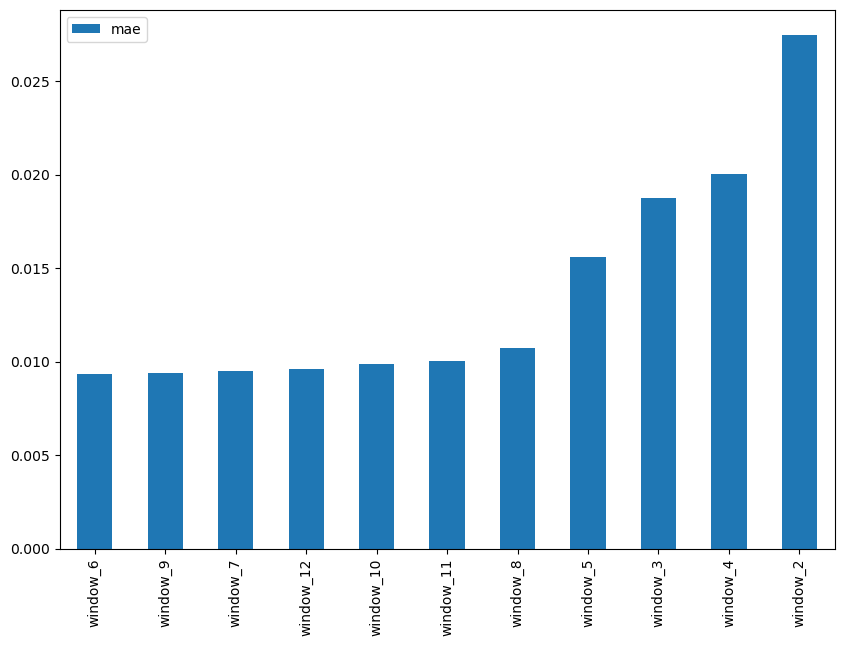

In [156]:
# Sort model results by MAE and plot them
metrics_for_windows_2_12[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

It works best with a window of size 6

## 4. Create a windowed dataset just like the ones we used for model_1 using tf.keras.preprocessing.timeseries_dataset_from_array() and retrain model_1 using the recreated dataset.

In [70]:
# Recreate windowed data with 
full_windows, full_labels = make_windows(prices, window_size=6)
len(full_windows), len(full_labels)

(2781, 2781)

In [71]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 557, 2224, 557)

In [31]:
import tensorflow as tf

In [32]:
train_dataset = tf.keras.utils.timeseries_dataset_from_array(train_windows,
                                                             train_labels,
                                                             sequence_length=1)

In [160]:
# Set random seed for a reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model 
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation.
], name="model_1_dense") # name our model so we can save it.

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

model_1.fit(train_dataset,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[CreateModelCheckpoint("C:/Users/User/Time_series/checkpoints/exercices/"+model_1.name,"val_loss", False)])

Epoch 1/100
 3/18 [====>.........................] - ETA: 2s - loss: 0.0070 - mae: 0.0070 - mse: 8.9735e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 1s 42ms/step - loss: 0.0437 - mae: 0.0437 - mse: 0.0052 - val_loss: 0.2467 - val_mae: 0.2467 - val_mse: 0.1243
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0138 - mae: 0.0138 - mse: 1.9205e-04

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 19ms/step - loss: 0.0203 - mae: 0.0203 - mse: 6.7676e-04 - val_loss: 0.0902 - val_mae: 0.0902 - val_mse: 0.0221
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0107 - mae: 0.0107 - mse: 1.1630e-04

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 19ms/step - loss: 0.0071 - mae: 0.0071 - mse: 8.0050e-05 - val_loss: 0.0244 - val_mae: 0.0244 - val_mse: 0.0020
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0093 - mae: 0.0093 - mse: 1.2818e-04 - val_loss: 0.0299 - val_mae: 0.0299 - val_mse: 0.0029
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0079 - mae: 0.0079 - mse: 1.6421e-04 - val_loss: 0.0350 - val_mae: 0.0350 - val_mse: 0.0040
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0124 - mae: 0.0124 - mse: 1.9813e-04 - val_loss: 0.0410 - val_mae: 0.0410 - val_mse: 0.0045
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0120 - mae: 0.0120 - mse: 3.1643e-04 - val_loss: 0.0278 - val_mae: 0.0278 - val_mse: 0.0025
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 0.0035 - mae: 0.0035 - mse: 1.4627e-05

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints/exercices\model_1_dense\assets


18/18 [==============================] - 0s 19ms/step - loss: 0.0099 - mae: 0.0099 - mse: 2.5920e-04 - val_loss: 0.0170 - val_mae: 0.0170 - val_mse: 8.4063e-04
Epoch 9/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0141 - mae: 0.0141 - mse: 3.4336e-04 - val_loss: 0.0332 - val_mae: 0.0332 - val_mse: 0.0032
Epoch 10/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0088 - mae: 0.0088 - mse: 1.8740e-04 - val_loss: 0.0198 - val_mae: 0.0198 - val_mse: 0.0013
Epoch 11/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0119 - mae: 0.0119 - mse: 2.8938e-04 - val_loss: 0.0344 - val_mae: 0.0344 - val_mse: 0.0034
Epoch 12/100
18/18 [==============================] - 0s 2ms/step - loss: 0.0077 - mae: 0.0077 - mse: 1.4952e-04 - val_loss: 0.0215 - val_mae: 0.0215 - val_mse: 0.0016
Epoch 13/100
18/18 [==============================] - 0s 3ms/step - loss: 0.0121 - mae: 0.0121 - mse: 2.8722e-04 - val_loss: 0.0330 - val_mae: 0.0330 - val_mse: 0.0032
E

In [161]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("C:/Users/User/Time_series/checkpoints/exercices/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 675us/step - loss: 0.0170 - mae: 0.0170 - mse: 8.4063e-04


[0.016985291615128517, 0.016985291615128517, 0.0008406336419284344]

In [162]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 442us/step


(557,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.15108006, 0.1489936 , 0.14842759, 0.14728001, 0.14488412,
        0.14499061, 0.14253043, 0.1420794 , 0.14149699, 0.13970944],
       dtype=float32)>)

In [163]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 0.016985295,
 'mse': 0.00084063364,
 'rmse': 0.028993683,
 'mape': 4.7659683,
 'mase': 1.8935542}

## 6. Make prediction intervals for future forecasts

In [33]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(train_windows)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)

test_features_dataset = tf.data.Dataset.from_tensor_slices(test_windows)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Ideal number of CPUs
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [34]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
    """
    Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.
    
    For example, if num_iter=10, a list of 30 trained models will be returned:
    10 * len(["mae", "mse", "mape"]).
    """
    # Make empty list for trained ensemble models
    ensemble_models = []
    
    # Create num_iter number of models per loss function 
    for i in range(num_iter):
        # Build and fit a new model with a different loss function
        for loss_function in loss_fns:
            print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")
            
            # Construct a simple model (similar to model_1)
            model = tf.keras.Sequential([
                # Initialize dense layers with normal distribution for estimating prediction intervals later on
                layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
                layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
                layers.Dense(HORIZON),
                
            ])
            
            # Compile simple model with current loss function
            model.compile(loss=loss_function,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["mae", "mse"])
            
            # Fit the current model
            model.fit(train_data,
                      epochs=num_epochs,
                      verbose=0,
                      validation_data=test_data,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                  patience=200,
                                                                  restore_best_weights=True),
                                tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                     patience=100,
                                                                     verbose=1)])
            
            # Appended fitted model to list of ensemble models
            ensemble_models.append(model)
            
    return ensemble_models

In [37]:
from tensorflow.keras import layers

In [38]:
%%time

# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 230: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 330: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 177: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 277: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 344: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 444: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 399: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 499: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 152: ReduceLROnPl

### Make predictions with our ensemble model

In [39]:
# Create  a function whiches uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [41]:
%%time
# Create a list of ensemble predictions

ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)

1/1 [==============================] - 0s 10ms/step
CPU times: total: 0 ns
Wall time: 214 ms


Our ensemble preds come out in multiple dimensions but to combine them into **point prediction** we can leverage the mean of all the predictions or the median

In [52]:
# Mean of the predictions
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)

In [53]:
# Median of the predictions
ensemble_median = np.median(ensemble_preds, axis=0)

In [56]:
# Evaluate our ensemble model predictions
ensemble_mean_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                       y_pred=ensemble_mean)
ensemble_mean_results

{'mae': 0.009388229,
 'mse': 0.00030759172,
 'rmse': 0.017538292,
 'mape': 2.6268775,
 'mase': 1.0466182}

In [57]:
# Evaluate our ensemble model predictions
ensemble_median_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                       y_pred=ensemble_median)
ensemble_median_results

{'mae': 0.009276437,
 'mse': 0.00030099752,
 'rmse': 0.01734928,
 'mape': 2.6025314,
 'mase': 1.0341555}

We will use the median results.

### Plotting the prediction intervals (uncertainty estimates) of our ensembles

In [58]:
# Find the upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized model 
    
    # 2. Measure the standard deviation of the predictions
    std = tf.math.reduce_std(preds, axis=0)
    
    # 3. Multiply the standard deviation by 1.96
    interval = 1.96 * std
    
    # 4. Get the prediction interval upper and lower bounds
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval
    
    return lower, upper

In [59]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)

In [61]:
import matplotlib.pyplot as plt

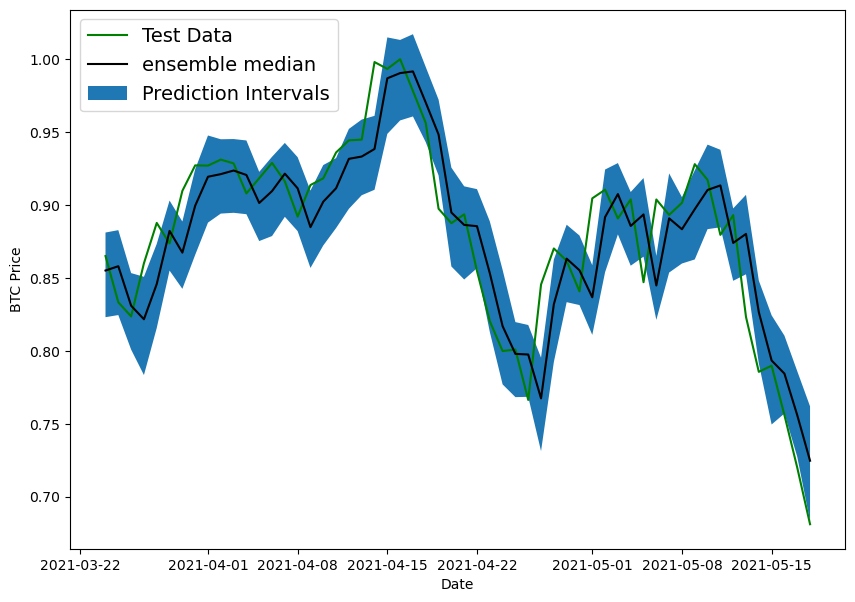

In [79]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the prediction fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset+1:], "k-", label="ensemble median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                (lower)[offset+1:],
                (upper)[offset+1:],
                 label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

So far all of our models predictions have been lagging behind the test data... As if they're replicating what the naive model does and just predict the previous timestep as the next timestep

### 7. Train a model on the full historical data to make predictions into the future

In [114]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(full_windows)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(full_labels)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [140]:
%%time

tf.random.set_seed(42)

# Create a model (nice and sample, just to test)
model_future = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="future_model")

# Compile
model_future.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit our model on all of the data to make future forecasts
model_future.fit(dataset_all,
                 epochs=100,
                 verbose=0,
                 callbacks=[CreateModelCheckpoint("C:/Users/User/Time_series/checkpoints/"+model_future.name,"loss", False)])

INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Time_series/checkpoints\future_model\assets


CPU times: total: 6.95 s
Wall time: 13.8 s


### Make predictions into future

In [258]:
# How many timesteps to predict int othe future ?
INTO_FUTURE = 12
WINDOW_SIZE = 6

In [94]:
# We need the next INTO_FUTURE dates
def get_future_dates(start_date, into_future, offset=1):
    """
    Returns array of datetime values ranging from start_date to start_date+into_future
    """
    start_date = start_date # Specify start date, D stand for day
    end_date = start_date + np.timedelta64(into_future, "D") + 1 # We need to add the timesteps plus the last one 
    return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [92]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [93]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [259]:
# Add retraining into make future predictions
def make_future_forecasts(values, windows, model, into_future, window_size=WINDOW_SIZE) -> list:
    """
    Make future forecasts into future steps after values ends.
    
    Returns future forecasts as a list of floats.
    """
    # 2. Create an empty list for future forecasts/prepare to forecast on
    future_forecast = [] 
    last_window = values[-WINDOW_SIZE-1:-1] # I start by predicting the last value in order to have no gap in my Bitcoins price's curve

    # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
    for _ in range(INTO_FUTURE): 
        
        # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

        # Append predictions to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())

        # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

        # Add our newest prediction
        values = np.append(values, future_pred)

        # Add new window
        windows = np.append(windows, last_window)
 
        # Turn data into efficient running tensors
        features_dataset_all = tf.data.Dataset.from_tensor_slices(windows)
        labels_dataset_all = tf.data.Dataset.from_tensor_slices(values)

        # Combine features and labels
        dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

        # Batch and prefetch
        BATCH_SIZE = 1024
        dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        
        # Fit our model on all of the data to make future forecasts
        model.fit(dataset_all,
                  epochs=100,
                  verbose=0,
                  callbacks=[CreateModelCheckpoint("C:/Users/User/Time_series/checkpoints/"+model_future.name,"loss", False)])
        
    return future_forecast

In [1]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=full_labels,
                                        windows=full_windows,
                                        model=model_future,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

In [2]:
# Plot future prices predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

### 📖 10. Time series fundamentals and Milestone Project 3: BitPredict 💰📈 Extra-curriculum

We've only really scratched the surface with time series forecasting and time series modelling in general. But the good news is, you've got plenty of hands-on coding experience with it already.

If you'd like to dig deeper in to the world of time series, I'd recommend the following:

* [Forecasting: Principles and Practice](https://otexts.com/fpp3/) is an outstanding online textbook which discusses at length many of the most important concepts in time series forecasting. I'd especially recommend reading at least Chapter 1 in full.
  * I'd definitely recommend at least checking out chapter 1 as well as the chapter on forecasting accuracy measures.
* 🎥 [Introduction to machine learning and time series](https://youtu.be/wqQKFu41FIw) by Markus Loning goes through different time series problems and how to approach them. It focuses on using the `sktime` library (Scikit-Learn for time series), though the principles are applicable elsewhere.
* [*Why you should care about the Nate Silver vs. Nassim Taleb Twitter war*](https://towardsdatascience.com/why-you-should-care-about-the-nate-silver-vs-nassim-taleb-twitter-war-a581dce1f5fc) by Isaac Faber is an outstanding discussion insight into the role of uncertainty in the example of election prediction.
* [TensorFlow time series tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series) - A tutorial on using TensorFlow to forecast weather time series data with TensorFlow.
* 📕 [*The Black Swan*](https://en.wikipedia.org/wiki/The_Black_Swan:_The_Impact_of_the_Highly_Improbable) by Nassim Nicholas Taleb - Nassim Taleb was a pit trader (a trader who trades on their own behalf) for 25 years, this book compiles many of the lessons he learned from first-hand experience. It changed my whole perspective on our ability to predict. 
* [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) by Skander Hannachi, Ph.D - time series data is different to other kinds of data, if you've worked on other kinds of machine learning problems before, getting into time series might require some adjustments, Hannachi outlines 3 of the most common.
* 🎥 World-class lectures by 
Jordan Kern, watching these will take you from 0 to 1 with time series problems: 
  * [Time Series Analysis](https://youtu.be/Prpu_U5tKkE) - how to analyse time series data.
  * [Time Series Modelling](https://www.youtube.com/watch?v=s3XH7fTHMb4) - different techniques for modelling time series data (many of which aren't deep learning).